In [1]:
!nvidia-smi

Wed Jun 30 15:18:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 25%   46C    P0    58W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 26%   45C    P0    58W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import time
import torch.optim as optim

from dataset import encoder
from model import get_pretrained_model
from dataset import jpg2np, get_loader
from torchvision import models
from bezier.hazmat.curve_helpers import evaluate_hodograph, get_curvature

In [3]:
GPU_NUM = 2
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print('Current cuda device ', torch.cuda.current_device())

Current cuda device  2


In [4]:
#############################
########  Network   #########
#############################
import bezier 
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        vgg16 = models.vgg16(pretrained=False)
        
        self.num_frames = 30
        
        self.embedding = vgg16.features
        
        self.spatial = nn.Linear(512, 101)
        self.temporal_1 = nn.Linear(512, 3)
        self.temporal_2 = nn.Linear(3, 1)
        
    def forward(self, x):
        try:
            embeddings = self.embedding(x)
            embeddings = nn.AdaptiveAvgPool2d((1,1))(embeddings).squeeze() 

            temporal_embeddings = self.temporal_1(embeddings)


            # Predict Img Class
            y1_hat = self.spatial(embeddings)


            # Predict the Curvature
#             y2_hat = self.temporal_2(temporal_embeddings)


            # Calculate the true Curvature
            temporal_embeddings = temporal_embeddings.cpu().detach().numpy()
            curve = self.bezier(temporal_embeddings)

            y2 = self.curvature(temporal_embeddings, curve)
        except:
            import pdb; pdb.set_trace()
        
        return y1_hat, y2, temporal_embeddings
#     return y1_hat, y2_hat, y2, temporal_embeddings
    
    
    def bezier(self, control_points):
        import bezier
        
        return bezier.Curve.from_nodes(control_points.T)
    
    
    def curvature(self, embeddings, curve):
        kappa = []
        for s in range(self.num_frames):
            t = s / self.num_frames
            tangent_vec = curve.evaluate_hodograph(t)
            kappa.append(get_curvature(embeddings.T, tangent_vec, t))
#             kappa.append(get_curvature(embeddings, tangent_vec, t))
            
        return np.array(kappa).reshape(-1, 1)
    
net = Network().to(device)

In [5]:
# import bezier
# nodes2 = np.random.rand(3,5)
# bezier.Curve.from_nodes(nodes2)

# bezier.Curve.from_nodes(temporal_embeddings.T)

In [6]:
#############################
### UCF101 dataset sample ###
#############################

dir_path = './ucf_image'
video_imgs_path = os.path.join(os.getcwd(), dir_path)
folders = os.listdir(video_imgs_path)

frames = {}
for folder in folders:
    path = os.path.join(video_imgs_path, folder)
    frames[folder] = len(os.listdir(path))
    
video_names = []


upper, lower = 150, 160
for video_name, num_of_frames in zip(list(frames.keys()), list(frames.values())):
    if upper <= num_of_frames and num_of_frames <= lower:
        video_names.append(video_name)
print("Select The number of frames between [%d, %d] of UCF101 Dataset" %(upper, lower))
print('The number of selected videos is', len(video_names))


with open("./labels.txt", 'w+') as f:
        for name in video_names: f.write(name+'\n')
            
            
with open('labels.txt', 'r') as f:
    y = f.readlines()

labels = []
for label in y:
    loc1 = label.find('_')
    loc2 = loc1 + label[loc1+1:].find('_')
    labels.append(label[loc1+1:loc2+1])
y, _ = encoder(labels)
y = torch.tensor(y, dtype=torch.float) # [N(13320, 1)

criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001,  weight_decay=1e-5)

Select The number of frames between [150, 160] of UCF101 Dataset
The number of selected videos is 500


In [7]:
#############################
##### Network Embedding #####
#############################

epochs = 10
c1 = torch.tensor(0).to(device)
c2 = torch.tensor(0).to(device)

start_ = time.time()
for epoch in range(epochs):
    correct = 0
    total = 0
    start = time.time()
    for i, file in enumerate(video_names[:10]):

        ## data setting ##
        path = os.path.join(dir_path, file)
        x = jpg2np(path) # (30, 3, 240, 320)
        x = torch.from_numpy(x).float().to(device)/255

        y1_true = torch.ones(30)*y[i]
        y1_true = y1_true.long().to(device)


        optimizer.zero_grad()
        y1_pred, y2_pred, y2_true, temporal_embeddings = net(x)
        
        y2_true = torch.from_numpy(y2_true).float().to(device)


#         ## Image Classification ##
        _, predicted = torch.max(y1_pred, 1)
        loss_cls = criterion1(y1_pred, y1_true)


#         ## Curvature Regression ##
#         loss_reg = criterion2(y2_pred, 1/y2_true)
        loss_reg = 1/ y2_true
        print('\n\n\n',loss_reg.sum().item())


#         ## Action Recognition + Cuvature loss ##
        loss = (c1* loss_cls) + (c2 * loss_reg.sum())
#         loss = 0

        loss.backward()
        optimizer.step()
# Loss:{:.4f} |Train acc: {:2.2f}
        correct += (predicted == y1_true).sum().item()
        total += y1_true.shape[0]
        train_acc = correct / total * 100
        print("Epoch:{} [{}/{}] | ACC {} | loss {} |{}".format(epoch+1, i+1,len(video_names[:10]),train_acc, loss_cls.item(), file))
        
#     acc = correct / total * 100
#     print("\n\nEpoch: [{}/{}] Acc: {:2.2f} Loss: {:.4f} Time: {:.2f}s\n\n".format(epoch+1, epochs,
#                                                                                   loss.item(), acc, time.time() - start))
# t = time.time()-start_
# print("ToTal Time: {}m {}s".format(t//60, t%60))    




 0.011779815889894962
Epoch:1 [1/10] | ACC 0.0 | loss 4.541859149932861 |v_ThrowDiscus_g12_c01



 0.22825519740581512
Epoch:1 [2/10] | ACC 0.0 | loss 4.559132099151611 |v_Skiing_g02_c05



 0.018312782049179077
Epoch:1 [3/10] | ACC 0.0 | loss 4.616072177886963 |v_PlayingTabla_g16_c02



 -0.02754540741443634
Epoch:1 [4/10] | ACC 0.0 | loss 4.610739231109619 |v_SoccerPenalty_g04_c05



 -0.050734393298625946
Epoch:1 [5/10] | ACC 0.0 | loss 4.6216511726379395 |v_HorseRace_g07_c06



 0.024198640137910843
Epoch:1 [6/10] | ACC 0.0 | loss 4.655975818634033 |v_Mixing_g14_c03



 0.03760938346385956
Epoch:1 [7/10] | ACC 0.0 | loss 4.569692611694336 |v_BaseballPitch_g13_c03



 0.05965018272399902
Epoch:1 [8/10] | ACC 0.0 | loss 4.638160228729248 |v_MilitaryParade_g12_c04



 -0.17688040435314178
Epoch:1 [9/10] | ACC 0.0 | loss 4.628687381744385 |v_BabyCrawling_g10_c05



 -0.3497459888458252
Epoch:1 [10/10] | ACC 0.0 | loss 4.643749713897705 |v_BlowingCandles_g06_c04



 -0.06721772998571

In [25]:
temporal_embeddings[:,:2]

array([[-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,  0.00766729],
       [-0.00119123,

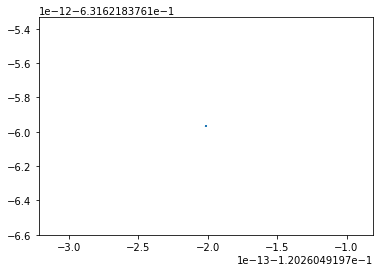

In [43]:
curve = bezier.Curve.from_nodes(temporal_embeddings[:,:2].T)
ax = curve.plot(num_pts=256)

In [39]:
loss_reg, loss_cls
y2_pred, y2_true
curve = bezier.Curve.from_nodes(temporal_embeddings.T)
kappa = []
for s in range(30):
    t = s / 30
    tangent_vec = curve.evaluate_hodograph(t)
    kappa.append(get_curvature(temporal_embeddings.T, tangent_vec, t))
kappa

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

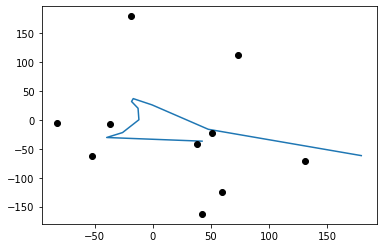

In [150]:
import bezier 

kappa = list()

curve = bezier.Curve.from_nodes(pca_embeddings.T)
ax = curve.plot(num_pts=10) 


ax.plot(
    pca_embeddings[0, :], pca_embeddings[1, :], pca_embeddings[2, :], 
    pca_embeddings[3, :], pca_embeddings[4, :], pca_embeddings[5, :],
    pca_embeddings[6, :], pca_embeddings[7, :], pca_embeddings[8, :], pca_embeddings[9, :], 
    marker="o", linestyle="None", color="black")